# Examen 1 de Machine Learning

### Presentado por: 
    - Diego Osorio, código:201513417
    - Jaime Roberto Muñoz, código:200027408

# Se importan las librerías que se requieran

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


import warnings
import math as m
warnings.filterwarnings('ignore')
import numpy as np
import missingno as msn
import pandas as pd   
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools
import seaborn as sb
import time
tiempo=time.time()

from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
start_time = time.time()
print("--- %s seconds ---" % (time.time() - start_time))

--- 6.818771362304688e-05 seconds ---


# Introducción

Para encontrar el emjor modelo posible que permita predecircon una muy buena precisión las etiquetas con base en los datos proporcionados, seguiremos los siguientes pasos:
- 1-Definir unas funciones auxiliares que nos ayudaran en el proceso de preparación de los datos y selección de variables
- 2-Cargar los datos
- 3-Análisis exploratorio y preparación de los datos
- 4-Selección de variables
- 5-Ajuste de modelos y selección del mejor modelo

# 1 .Funciones auxiliares

Se definen funciones auxiliares para estandarizar, categorizar variables continuas y calcular el IV y el WoE de las variables categorizadas.   Varias de estas funciones son tomadas de del material de curso Machine Learning del profesor Fernando Lozamo. 

In [2]:
# Función para estandarizar las variables continuas
def estandarizacion(df):
    return df.apply(lambda x: (x-x.mean())/x.std(), axis=0)

# Cálculo de IV #Tomada del material del curso Machine Learning Profesor Fernando Lozano.
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('El IV de esta variable es:',iv)
    print(df[feature].value_counts())
    return iv, data

# Matriz de Confusión  #Tomada del material del curso Machine Learning Profesor Fernando Lozano.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta')
    plt.xlabel('Predicción')
    
# Codificación One-Hot #Tomada del material del curso Machine Learning Profesor Fernando Lozano.
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

def convert_dummy2(df):
    pd.get_dummies(df, drop_first=True)
    return df

#Tomada del material del curso Machine Learning Profesor Fernando Lozano.
def get_category(df, col, binsnum, labels, prefijo, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = prefijo + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

### Paso 2: Cargue de los datos

In [3]:
from pathlib import Path
d = Path().resolve().parent
str(d)

'/'

In [4]:
#Se cargan las variables descriptoras
Xdata = pd.read_csv("xtrain.txt", header=None, sep='\s+')
Xdata.head(10)

FileNotFoundError: ignored

In [ ]:
#Se carganlas etiquetas
Ydata = pd.read_csv("ytrain.txt", header=None)
Ydata.head(10)

,0
0,1.0
1,0.0
2,0.0
3,1.0
4,1.0
5,1.0
6,0.0
7,0.0
8,0.0
9,1.0


## Paso 3. Análisis exploratorio y preparación de los datos


El análisis exploratiorio tiene por objetivo saber como son las distribuciones de las variables descriptoras y además determinar si las clases que se pretenden identificar están balanceadas.   Así mismo, se revisa si existen valores perdidos, se estandarizan las variables de tal manera que tengan media = 0 y varianza = 1, y se revisa la correlación exitente entre las variables.  

Dado que las variables de este problema no se pueden poner en contexto, es por ejemplo complicado saber si dos variables que tienen una correlación alta están brindando la misma información, por lo que una de ellas sería redundante o si por el contrario a pesar de estar correlacionadas miden cosas distintas.

Finalmente se hacen los histogramas de cada variable para saber como son sus distribuciones, lo que será útil al momento de tener que realizar transformación de variables.


<AxesSubplot:ylabel='0'>

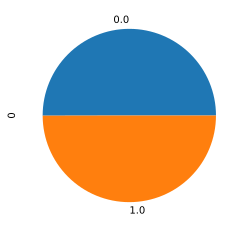

In [ ]:
#Se revisa si las clases están balanceadas
Ydata[0].value_counts().plot(kind='pie')

El gráfico anterior muestra que los datos se encuentran balanceados pues cada categoría de la etiqueta tiene el 50% de los datos.

Por otro lado en la grafica siguiente no se encuentran valores perdidos en los datos, que se ven representados en la gráfica como espacios en blanco.  Como se puede observar no existen.

<AxesSubplot:>

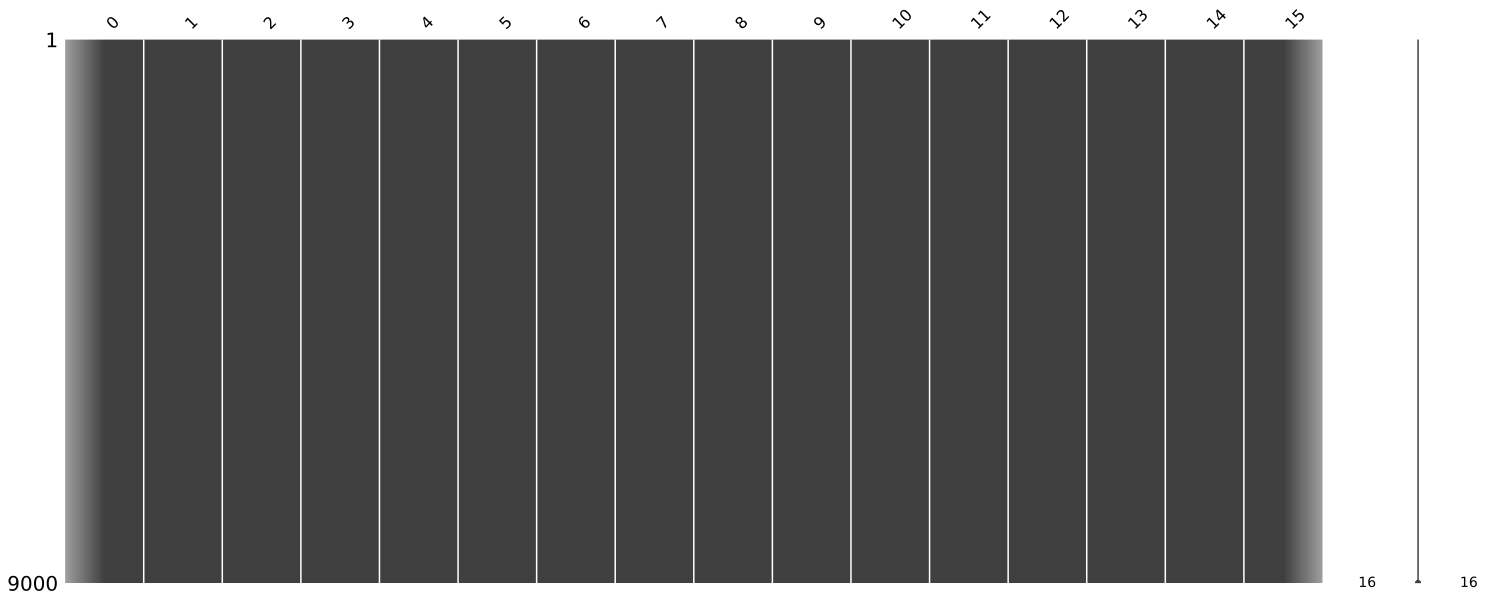

In [ ]:
msn.matrix(Xdata)

El siguiente gráfico es un mapa de calor donde se muestran las correlaciones entre las variables, las correlaciones más altas a aparecen en azul oscuro o blanco.  Se puede observar que las variables 0, 1,2,3,6 y 12 se encuentran muy correlacionadas junto con la 14, 13 11 y 10; también la 15 con la 10. 

Desafortunadamente al no tener estas variables contexto, no podemos saber, como se dijo anteriormente si las variables altamente correlacionadas son redundantes o no.

<AxesSubplot:>

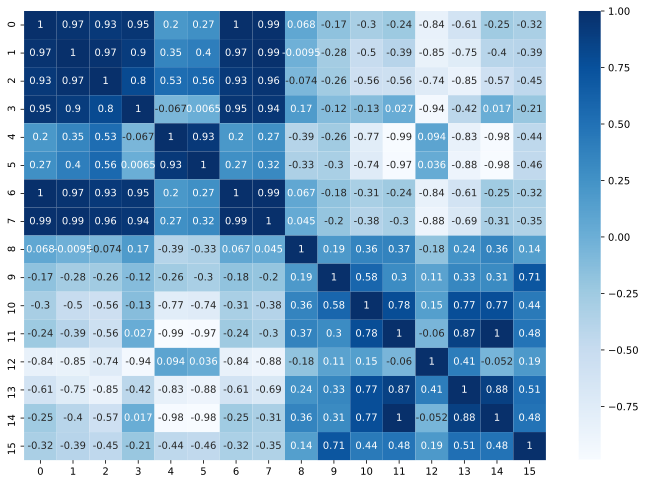

In [ ]:
correl = Xdata.corr()
rcParams['figure.figsize'] = 11.7,8.27
sb.heatmap(correl, cmap="Blues", annot=True)

Debido a las diferencia dimensionales entre las variables, que se evidencia disimiltud en la magnitud de valores que toman, Se procede a estandarízar las variables continuas, para ello se hace una función Estandarización, según lo sugiere el Libro Elements of Statistical Learning, páginas 398-400.

In [ ]:
XdataEst = estandarizacion(Xdata)
XdataEst.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.549056,-0.774288,-0.962352,-0.070251,-1.463149,-1.856969,-0.555827,-0.597450,0.358633,1.039852,1.672519,1.660089,-0.142959,1.513182,1.717682,0.706257
1,-0.626380,-0.707437,-0.710874,-0.662114,-0.291320,0.018311,-0.625590,-0.708909,-0.595637,-0.088408,0.178511,0.183947,0.714476,0.396986,0.142015,0.380515
2,-0.346858,-0.395211,-0.393330,-0.230728,-0.343911,-0.034514,-0.352208,-0.320637,0.637957,0.665042,0.561877,0.235567,0.076289,0.139872,0.194054,0.232319
3,0.468754,0.639619,0.702171,0.505147,0.373264,0.556315,0.489303,0.641623,0.301199,-1.873106,-0.341414,-0.507984,-0.727132,-0.777332,-0.534120,-1.330355
4,0.754127,1.098725,0.633525,1.154292,-0.449122,-0.145939,0.762335,0.936887,-0.579545,-0.788368,-1.261142,0.356450,-1.326585,-0.455232,0.316787,0.466011
5,0.847451,1.090258,1.263857,0.698472,0.902008,0.861776,0.880941,1.029914,0.686271,-2.586312,-0.767084,-0.978898,-0.886170,-1.113085,-0.971489,-2.364180
6,-0.505869,-0.517409,-0.478836,-0.580709,0.010107,0.289040,-0.505519,-0.536625,-0.676044,-0.048263,-0.053156,-0.124015,0.584466,0.045846,-0.163840,0.310671
7,-0.584970,-0.717383,-0.601441,-0.668165,-0.079150,0.214111,-0.589101,-0.648798,0.561655,0.666940,0.737187,-0.035144,0.725861,0.189564,-0.076387,0.335683
8,0.151250,0.444083,0.874348,-0.350207,1.991597,1.292013,0.142752,0.290955,1.615478,0.721716,-1.154468,-1.702592,0.259989,-1.196369,-1.607642,-0.456721
9,1.208434,1.309487,1.447092,1.133075,0.597255,0.696084,1.198103,1.375459,-1.579100,0.466869,-0.203524,-0.679701,-1.291160,-1.085040,-0.695744,-0.474959


Creamos un dataframe que contiene las variables descriptoras estandarizadas y la variable de respuesta llamada Etiqueta.

In [ ]:
df=XdataEst
df['Etiqueta']=Ydata[0]
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,Etiqueta
0,-0.549056,-0.774288,-0.962352,-0.070251,-1.463149,-1.856969,-0.555827,-0.597450,0.358633,1.039852,1.672519,1.660089,-0.142959,1.513182,1.717682,0.706257,1.0
1,-0.626380,-0.707437,-0.710874,-0.662114,-0.291320,0.018311,-0.625590,-0.708909,-0.595637,-0.088408,0.178511,0.183947,0.714476,0.396986,0.142015,0.380515,0.0
2,-0.346858,-0.395211,-0.393330,-0.230728,-0.343911,-0.034514,-0.352208,-0.320637,0.637957,0.665042,0.561877,0.235567,0.076289,0.139872,0.194054,0.232319,0.0
3,0.468754,0.639619,0.702171,0.505147,0.373264,0.556315,0.489303,0.641623,0.301199,-1.873106,-0.341414,-0.507984,-0.727132,-0.777332,-0.534120,-1.330355,1.0
4,0.754127,1.098725,0.633525,1.154292,-0.449122,-0.145939,0.762335,0.936887,-0.579545,-0.788368,-1.261142,0.356450,-1.326585,-0.455232,0.316787,0.466011,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.093613,0.378953,0.780598,-0.405406,1.937320,1.275080,0.090056,0.224398,-1.354410,0.251748,-1.154973,-1.644089,0.311964,-1.150740,-1.557836,0.522777,0.0
8996,0.437172,0.831203,0.699108,0.410649,0.492297,0.632684,0.449248,0.607859,-1.005722,-1.176671,-1.549225,-0.577769,-0.663361,-0.798523,-0.600100,-0.033861,1.0
8997,-0.626638,-0.833696,-0.910054,-0.410440,-0.991603,-0.877504,-0.632690,-0.709287,-0.098565,1.012028,1.293162,1.015027,0.307970,1.062198,1.006812,0.927206,1.0
8998,-0.081528,0.100921,0.494164,-0.520546,1.656873,1.181195,-0.088059,0.015889,0.988480,0.643806,-0.701157,-1.461935,0.488353,-0.997309,-1.400935,0.379009,0.0


Renobramos las variables para facilitar su manejo

In [ ]:
df.rename(columns={0:'Var_0',1:'Var_1', 2:'Var_2',3:'Var_3',4:'Var_4',5:'Var_5',6:'Var_6',7:'Var_7',8:'Var_8',
                   9:'Var_9',10:'Var_10',11:'Var_11',12:'Var_12',13:'Var_13',14:'Var_14',15:'Var_15'},inplace=True)
df.head(10)

,Var_0,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,Var_7,Var_8,Var_9,Var_10,Var_11,Var_12,Var_13,Var_14,Var_15,Etiqueta
0,-0.549056,-0.774288,-0.962352,-0.070251,-1.463149,-1.856969,-0.555827,-0.597450,0.358633,1.039852,1.672519,1.660089,-0.142959,1.513182,1.717682,0.706257,1.0
1,-0.626380,-0.707437,-0.710874,-0.662114,-0.291320,0.018311,-0.625590,-0.708909,-0.595637,-0.088408,0.178511,0.183947,0.714476,0.396986,0.142015,0.380515,0.0
2,-0.346858,-0.395211,-0.393330,-0.230728,-0.343911,-0.034514,-0.352208,-0.320637,0.637957,0.665042,0.561877,0.235567,0.076289,0.139872,0.194054,0.232319,0.0
3,0.468754,0.639619,0.702171,0.505147,0.373264,0.556315,0.489303,0.641623,0.301199,-1.873106,-0.341414,-0.507984,-0.727132,-0.777332,-0.534120,-1.330355,1.0
4,0.754127,1.098725,0.633525,1.154292,-0.449122,-0.145939,0.762335,0.936887,-0.579545,-0.788368,-1.261142,0.356450,-1.326585,-0.455232,0.316787,0.466011,1.0
5,0.847451,1.090258,1.263857,0.698472,0.902008,0.861776,0.880941,1.029914,0.686271,-2.586312,-0.767084,-0.978898,-0.886170,-1.113085,-0.971489,-2.364180,1.0
6,-0.505869,-0.517409,-0.478836,-0.580709,0.010107,0.289040,-0.505519,-0.536625,-0.676044,-0.048263,-0.053156,-0.124015,0.584466,0.045846,-0.163840,0.310671,0.0
7,-0.584970,-0.717383,-0.601441,-0.668165,-0.079150,0.214111,-0.589101,-0.648798,0.561655,0.666940,0.737187,-0.035144,0.725861,0.189564,-0.076387,0.335683,0.0
8,0.151250,0.444083,0.874348,-0.350207,1.991597,1.292013,0.142752,0.290955,1.615478,0.721716,-1.154468,-1.702592,0.259989,-1.196369,-1.607642,-0.456721,0.0
9,1.208434,1.309487,1.447092,1.133075,0.597255,0.696084,1.198103,1.375459,-1.579100,0.466869,-0.203524,-0.679701,-1.291160,-1.085040,-0.695744,-0.474959,1.0


In [ ]:
namelist = ['Var_0', 'Var_1','Var_2','Var_3','Var_4','Var_5','Var_6','Var_7','Var_8','Var_9','Var_10','Var_11','Var_12',
           'Var_13','Var_14','Var_15']
for var in namelist:
    print('Análisis variable', var)
    df[var] = df[var].astype(object)
    print(df[var].value_counts(bins=10,sort=False))
   

Análisis variable Var_0
(-1.2089999999999999, -0.454]    3105
(-0.454, 0.293]                  3592
(0.293, 1.04]                    1739
(1.04, 1.787]                     130
(1.787, 2.533]                     19
(2.533, 3.28]                     105
(3.28, 4.027]                     169
(4.027, 4.774]                    104
(4.774, 5.52]                      30
(5.52, 6.267]                       7
Name: Var_0, dtype: int64
Análisis variable Var_1
(-1.6949999999999998, -1.052]     851
(-1.052, -0.416]                 2802
(-0.416, 0.22]                   2098
(0.22, 0.856]                    2021
(0.856, 1.492]                    749
(1.492, 2.128]                     55
(2.128, 2.764]                     97
(2.764, 3.4]                      202
(3.4, 4.036]                      103
(4.036, 4.672]                     22
Name: Var_1, dtype: int64
Análisis variable Var_2
(-1.73, -1.094]     1191
(-1.094, -0.466]    2135
(-0.466, 0.161]     1831
(0.161, 0.789]      2352
(0.789, 1.417]  

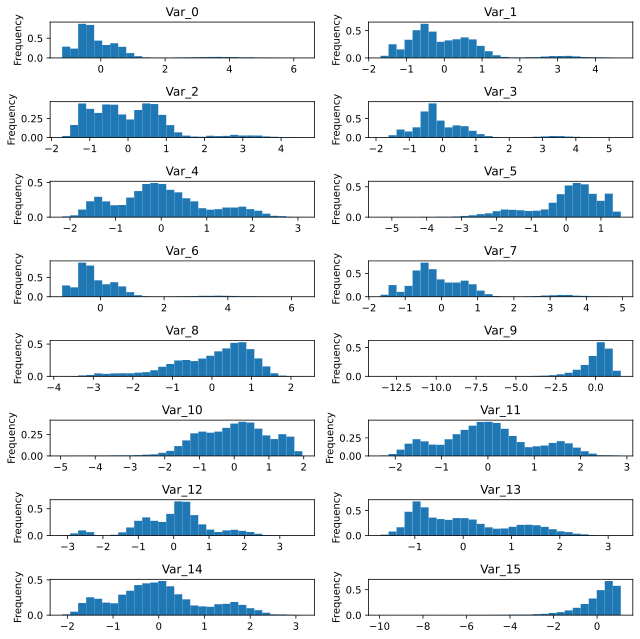

In [ ]:
nrow=8
ncol=2
fig, axes = plt.subplots(nrow, ncol)

# Para generar histogramas de cada variable##
plt.rcParams["figure.figsize"] = (12,12)
contador=0
for f in range(nrow):
    for c in range(ncol):
        df[namelist[contador]].plot(kind='hist', bins= 30, density=True, ax=axes[f,c])
        axes[f,c].title.set_text(namelist[contador])
        contador=contador+1
#Espaciando
fig.tight_layout()
plt.show()
    

Los histogramas permiten observar el comportamiento de las variables, y esto permite de ser necesario encontrar las transformaciones más adecuadas en caso de requerirse. 

Los histogramas en este caso nos permiten observar lo siguiente:
   - Var_0: Muestra una distribución sesgada por derecha.
   - Var_1: Muestra bimodal con sesgo postivo.
   - Var_2: Distribución multimodal con sesgo positivo.
   - Var_3: Distribución multimodal con sesgo positivo.
   - Var_4: Distribución muestra tres modas y es ligeramente sesgada por derecha.
   - Var_5: Distribución con sesgo negativo.
   - Var 6: Distribución sesgada por derecha.
   - Var 7: Distribución con sesgo Positivo.
   - Var 8: Distribución con sesgo negativo y dos modas.
   - Var 9: Distribución con sesgo negativo.
   - Var 10: Distribución con sesgo negativo y dos modas.
   - Var 11: Distribución más o menos simétrica con tres modas.
   - Var 12: Distribución más o menos simétrica con tres modas.
   - Var 13: Distribución con sesgo postivo multimodal.
   - Var 14: Distribución más o menos simétrica multimodal.
   - var 15: Distribución con sesgo negativo.
   
 A continuacion categorizamos las todas variables originales en 3 grupos, y de acuerdo con los resultados aumentaremos o disminuiremos la cantidad de categorías, buscando como categorizar de menor manera las variables continuas y al mismo tiempo mejorar su poder predictivo, con el fin de ayudar a que el modelo sea mejor clasificando.  A cada intento le dimos un prefijo diferente para poder diferenciarlos posteriormente.  
 
Es importante mencionar que a las variables obtenidas se les coloca el prefijo gp.

## Paso 4. Selección de variables con IV y WoE


Teniendo en cuenta que todas las variables son continuas y ya tenieénolas estandarizadas, vamos a revisar su aporte en la clasificación usando IV (information Value) y Weight of evidence (WoE). 

WoE e IV pueden ser usados para cuantificar y entender el poder predictivo de una variable con la desventaja que es una análisis individual por variable, es decir tiene en cuenta interacciones entre las variables.  A continuación se muestra como se definen estos valores.

![image.png](attachment:image.png)

![image-2.png](attachment:image-2.png)

Tomado de:https://medium.com/mlearning-ai/weight-of-evidence-woe-and-information-value-iv-how-to-use-it-in-eda-and-model-building-3b3b98efe0e8

Dependiento el valor que tomen se determina su poder predictivo con base el IV y si la variable se encuentra bien categorizda con el WoE.  Si una variable está bien categorizada su WoE decrece o crece monotónicamente entre las categorías adyacentes.

Los valores de referencia que se toman en cuenta son:

![image-3.png](attachment:image-3.png)

Tomado de:https://medium.com/mlearning-ai/weight-of-evidence-woe-and-information-value-iv-how-to-use-it-in-eda-and-model-building-3b3b98efe0e8

Buscamos variables que cuyo IV este en el rango $0.1 \leq IV \leq 0.5$ que pues son las que tienen un poder predictivo medio a fuerte.  Las que están por debajo de este rango las analizaremos para ver si con una transformación y/o creando una interaccion pueden mejorar.

Las que tienen un IV superior a 0.5 son sospechosas y también las analizaremos para ver si una transformación y/o una interacción mejora su índice IV.  Este proceso se hace un poco más complicado al no tener variables sin contexto, pero exploraremos posibilidades teniendo en cuenta el tiempo de ejecución de los modelos y el plazo de entrega del exámen, el objetivo obtener el mejor modelo posible.

En primera instancia categorizamos todas las variables en tres categorías Alta, Media y Baja y se hace el análisis del WoE y el IV.  A las variables que se generan de este primer análisis se les antepone el prefijo gp.

In [ ]:
#Se crea la tabla IV
ivtable=pd.DataFrame(df.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['Var_0', 'Var_1','Var_2','Var_3','Var_4','Var_5','Var_6','Var_7','Var_8','Var_9','Var_10','Var_11','Var_12',
           'Var_13','Var_14','Var_15']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

ivtable.head()

,variable,IV
16,Etiqueta,None


In [ ]:
# Se categorizan las variables y se revisa si la categorización es adecuada y su poder de predicción de acuerdo con lo ya explicado.
for var in namelist:
    print('Variable:',var)
    print('')
    df = get_category(df, var, 3, ["Bajo", "Medio", "Alto"], 'gp', qcut = True)
    iv, data = calc_iv(df,'gp_'+var,'Etiqueta')
    ivtable.loc[ivtable['variable']== 'gp_'+var,'IV']=iv
    print('')
    print(data)
    print('')

Variable: Var_0

El IV de esta variable es: 1.6995068037058123
Alto     3000
Medio    3000
Bajo     3000
Name: gp_Var_0, dtype: int64

   Variable  Value   All  Good   Bad     Share  Bad Rate  Distribution Good  \
0  gp_Var_0   Alto  3000   342  2658  0.333333  0.886000           0.075949   
1  gp_Var_0   Bajo  3000  1721  1279  0.333333  0.426333           0.382190   
2  gp_Var_0  Medio  3000  2440   560  0.333333  0.186667           0.541861   

   Distribution Bad       WoE        IV  
0          0.591061 -2.051852  1.056932  
1          0.284412  0.295494  0.028893  
2          0.124527  1.470483  0.613682  

Variable: Var_1

El IV de esta variable es: 1.5674273530955616
Alto     3000
Medio    3000
Bajo     3000
Name: gp_Var_1, dtype: int64

   Variable  Value   All  Good   Bad     Share  Bad Rate  Distribution Good  \
0  gp_Var_1   Alto  3000   426  2574  0.333333  0.858000           0.094604   
1  gp_Var_1   Bajo  3000  1583  1417  0.333333  0.472333           0.351543   
2  gp_V

El IV de esta variable es: 0.28369472785458594
Alto     3000
Medio    3000
Bajo     3000
Name: gp_Var_15, dtype: int64

    Variable  Value   All  Good   Bad     Share  Bad Rate  Distribution Good  \
0  gp_Var_15   Alto  3000  1063  1937  0.333333  0.645667           0.236065   
1  gp_Var_15   Bajo  3000  1425  1575  0.333333  0.525000           0.316456   
2  gp_Var_15  Medio  3000  2015   985  0.333333  0.328333           0.447479   

   Distribution Bad       WoE        IV  
0          0.430732 -0.601379  0.117068  
1          0.350233 -0.101417  0.003426  
2          0.219035  0.714399  0.163201  



Analizando el IV y WoE podemos decir:

- Las variables gp_Var_0, gp_Var_1, gp_Var_2, gp_Var_3,gp_Var_6, gp_Var_7, gp_Var_12; tienen un IV mayor a 0.5 lo que hace sospechosas, demasiado bueno para ser cierto.  El WoE de estas variables tiene el comportamiento monotónico deseado, excepto para la variable gp_Var_12.

- Las variables: gp_Var_4, gp_Var_5, gp_Var_8, gp_Var_11; Hay que revisar la cantidad de categorías pues el WoE no es monotónico, es decir a medida que se deciende en el orden de las categorias no tiene una tendencia de descenso o ascenso, sino que aumenta y luego baja visceversa.
- Las variables: gp_Var_9,  gp_Var_14, gp_Var_15; Tienen un IV que muestra un poder predictivo entre medio y fuerte.
- Las variables: gp_Var_13 y gp_Var_10  tienen un poder predictivo debil o no tienen y un WoE monotónico que se puede observar al revisar su comportamiento en las categorías.

Con base en lo anterior exploraremos cambiar la agrupación de las variables sospechosas al momento de categorizar IV > 0.5, exploraremos otras categorizaciones para aquellas cuyo WoE no fue monotónico y la creación de unas nuevas variables de interacción, por ejemplo entre Var_13 y Var_10 que por si solas no tiene un poder predictivo fuerte.  Agregamos a la lista de variables una interacción, Var_1310, que definieremos más adelante.
 

In [ ]:
#Se crea la tabla IV
ivtable=pd.DataFrame(df.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['Var_0', 'Var_1','Var_2','Var_3','Var_4','Var_5','Var_6','Var_7','Var_8','Var_9','Var_10','Var_11','Var_12',
           'Var_13','Var_14','Var_15', 'Var_1310']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

ivtable.head()

,variable,IV
16,Etiqueta,None
17,gp_Var_0,None
18,gp_Var_1,None
19,gp_Var_2,None
20,gp_Var_3,None


Para transformar las variables Var_13 y Var_10, se utilizó la escalera de Tukey que utiliza transformaciones de potencias.  Esta metodología es explicada en el libro: Tukey, J. W. (1977). Exploratory Data Analysis. Addison-Wesley, Reading, MA.  

La escalera es la que se muestra a continuación:

![image.png](attachment:image.png)
Tomada de: https://onlinestatbook.com/2/transformations/tukey.html

Hacia la izquierda se dice que se baja en la escalera y hacia la derecha se sube.  La variable sin transformar es $X^1$.

Si la varible tiene una distribucion con sesgo negativo se baja y si tiene sesgo positivo se baja hasta que se llegue a una simetrización que se considere suficiente de la distribución.

En nuestro caos la variable Var_13 tiene sesgo positivo y se baja hasta que $\lambda = -1$  y para Var_10 que tiene sesgo negativo se sube hasta que $\lambda = 2$.

A continuación generamos variable Var_1310 que resulta de la interacción de las variables Var_13 y Var_10 transformadas como se acaba de explicar.  Luego exploramos como categorizar Var_1310 en 3 categorías y le anteponemos a la variable categórica creada el prefijo gpI1.

In [ ]:
#Primero creamos la variable de la interacción entre Var_13 y Var10  que llamamos Var_1310

# La trasnformacion que se muestra a cotinuación se basa en la Escalera de Tukey.  Al tener Var_13 un sesgo positivo se baja
# en la escalera y se hace la transformación 1/Var_13 y al tener Var_10 un sesgo negativo se sube en la escalera y se transforma
# elevando la variable a cuadrado.

df['Var_1310'] = 1/df['Var_13']*(df['Var_10']*df['Var_10'])

#Ahora exploramos la categorización de esta nueva variable

df = get_category(df, 'Var_1310', 3, ["Bajo", "Medio", "Alto"], 'gpI1', qcut = True)
iv, data = calc_iv(df,'gpI1_Var_1310','Etiqueta')
ivtable.loc[ivtable['variable']== 'gpI1_'+var,'IV']=iv
print('')
print(data)
print('')

El IV de esta variable es: 0.12365258332422537
Alto     3000
Medio    3000
Bajo     3000
Name: gpI1_Var_1310, dtype: int64

        Variable  Value   All  Good   Bad     Share  Bad Rate  \
0  gpI1_Var_1310   Alto  3000  1391  1609  0.333333  0.536333   
1  gpI1_Var_1310   Bajo  3000  1862  1138  0.333333  0.379333   
2  gpI1_Var_1310  Medio  3000  1250  1750  0.333333  0.583333   

   Distribution Good  Distribution Bad       WoE        IV  
0           0.308905          0.357794 -0.146923  0.007183  
1           0.413502          0.253058  0.491046  0.078786  
2           0.277593          0.389148 -0.337806  0.037684  



La variable categórica creada es gpI1_Var1310, observamos que el WoE obtenido no se comporta de manera monotónica, por lo anterior aumentamos las categorías, lo que también ayudará a aumentar el poder productivo de esta nueva variable de interacción. Hacemos de nuevo la categorización y le ponemos el prefijo a gpI2 a la nueva variable.

In [ ]:
df = get_category(df, 'Var_1310', 4, ["Muy bajo", "Bajo", "Medio", "Alto"], 'gpI2', qcut = True)
iv, data = calc_iv(df,'gpI2_Var_1310','Etiqueta')
ivtable.loc[ivtable['variable']== 'gpI2_'+var,'IV']=iv
print('')
print(data)
print('')

El IV de esta variable es: 0.22072824101163868
Alto        2250
Muy bajo    2250
Medio       2250
Bajo        2250
Name: gpI2_Var_1310, dtype: int64

        Variable     Value   All  Good   Bad  Share  Bad Rate  \
0  gpI2_Var_1310      Alto  2250   861  1389   0.25  0.617333   
1  gpI2_Var_1310      Bajo  2250   870  1380   0.25  0.613333   
2  gpI2_Var_1310     Medio  2250  1347   903   0.25  0.401333   
3  gpI2_Var_1310  Muy bajo  2250  1425   825   0.25  0.366667   

   Distribution Good  Distribution Bad       WoE        IV  
0           0.191206          0.308873 -0.479578  0.056430  
1           0.193205          0.306871 -0.462679  0.052591  
2           0.299134          0.200801  0.398579  0.039194  
3           0.316456          0.183456  0.545210  0.072513  



En el resultado anterior, se puede observar que al aumentar a 4 categorías mejoro el IV a 0.22 y WoE crece monotónicamente por lo tanto usaremos gpI2_Var1310.

Dado que utilizaremos en algunos de nuestros modelos la variable de interacción, también analizaremos como se comportan las variables individuales Var_13 y Var_10 transformadas, con el objetivo de mantener el orden jerárquico, es decir que si está la interacción en el modelo incluir también las variables que interctuan individualmente.  A las variables Transformadas y categorizadas les ponemos el prefijo gpT

In [ ]:
# Se crean las variables que interactuan haciendo las mismas transforaciones utilizadas para generar la interacción
df['Var_13T'] = 1/df['Var_13']
df['Var_10T'] = df['Var_10']*df['Var_10']

#Categorizamos y calculamos la IV para Var_13T
df = get_category(df, 'Var_13T', 3, ["Bajo", "Medio", "Alto"], 'gpT', qcut = True)
iv, data = calc_iv(df,'gpT_Var_13T','Etiqueta')
ivtable.loc[ivtable['variable']== 'gpT_'+var,'IV']=iv
print('')
print(data)
print('')

df = get_category(df, 'Var_10T', 3, ["Bajo", "Medio", "Alto"], 'gpT', qcut = True)
iv, data = calc_iv(df,'gpT_Var_10T','Etiqueta')
ivtable.loc[ivtable['variable']== 'gpT_'+var,'IV']=iv
print('')
print(data)
print('')


El IV de esta variable es: 0.15295834749971113
Bajo     3001
Alto     3000
Medio    2999
Name: gpT_Var_13T, dtype: int64

      Variable  Value   All  Good   Bad     Share  Bad Rate  \
0  gpT_Var_13T   Alto  3000  1904  1096  0.333333  0.365333   
1  gpT_Var_13T   Bajo  3001  1369  1632  0.333444  0.543819   
2  gpT_Var_13T  Medio  2999  1230  1769  0.333222  0.589863   

   Distribution Good  Distribution Bad       WoE        IV  
0           0.422829          0.243718  0.550956  0.098682  
1           0.304020          0.362909 -0.177059  0.010427  
2           0.273151          0.393373 -0.364734  0.043849  

El IV de esta variable es: 0.16992275875633533
Alto     3000
Medio    3000
Bajo     3000
Name: gpT_Var_10T, dtype: int64

      Variable  Value   All  Good   Bad     Share  Bad Rate  \
0  gpT_Var_10T   Alto  3000  1121  1879  0.333333  0.626333   
1  gpT_Var_10T   Bajo  3000  1512  1488  0.333333  0.496000   
2  gpT_Var_10T  Medio  3000  1870  1130  0.333333  0.376667   

   Di

Las dos variables transformadas tienen un WoE Monotónico y un IV entre 0.1 y 0.3 que indica un poder predictivo medio.

In [ ]:
#Se crea la tabla IV actualizada con la variable de interacción y las dos variables transformadas.
ivtable=pd.DataFrame(df.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['Var_0', 'Var_1','Var_2','Var_3','Var_4','Var_5','Var_6','Var_7','Var_8','Var_9','Var_10','Var_11','Var_12',
           'Var_13','Var_14','Var_15', 'Var_1310','Var_10T', 'Var_13T']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

ivtable.head()

,variable,IV
16,Etiqueta,None
17,gp_Var_0,None
18,gp_Var_1,None
19,gp_Var_2,None
20,gp_Var_3,None


A continuación, revisamos las variables que desués de hacer una primera categorización, su WoE no era monotónico.  Estas variables son: Var_4, Var_5, Var_8 y Var_11 y les ponemos el prefijo gp2

In [ ]:
namelist2= ['Var_4','Var_5','Var_8','Var_11']
for var in namelist2:
    print('Variable:',var)
    print('')
    df = get_category(df, var, 4, ["Muy Bajo", "Medio", "Alto","Muy alto"], 'gp2', qcut = True)
    iv, data = calc_iv(df,'gp2_'+var,'Etiqueta')
    ivtable.loc[ivtable['variable']== 'gp2_'+var,'IV']=iv
    print('')
    print(data)
    print('')

Variable: Var_4

El IV de esta variable es: 0.8428038821070075
Alto        2250
Medio       2250
Muy Bajo    2250
Muy alto    2250
Name: gp2_Var_4, dtype: int64

    Variable     Value   All  Good   Bad  Share  Bad Rate  Distribution Good  \
0  gp2_Var_4      Alto  2250   971  1279   0.25  0.568444           0.215634   
1  gp2_Var_4     Medio  2250  1528   722   0.25  0.320889           0.339329   
2  gp2_Var_4  Muy Bajo  2250   399  1851   0.25  0.822667           0.088608   
3  gp2_Var_4  Muy alto  2250  1605   645   0.25  0.286667           0.356429   

   Distribution Bad       WoE        IV  
0          0.284412 -0.276841  0.019040  
1          0.160551  0.748356  0.133790  
2          0.411608 -1.535853  0.496081  
3          0.143429  0.910295  0.193893  

Variable: Var_5

El IV de esta variable es: 0.8428038821070075
Alto        2250
Medio       2250
Muy Bajo    2250
Muy alto    2250
Name: gp2_Var_5, dtype: int64

    Variable     Value   All  Good   Bad  Share  Bad Rate  Distr

Al aumentar las categorías en todas las variables el WoE no es monotónico y el IV, excepto Var_8 aumento por encima de 0.5, por lo que ahora intentaremos disminuirlas. A las variables creada en este nuevo intento de categorización les poenemos el prefijo gp3.

In [ ]:
namelist2= ['Var_4','Var_5','Var_8','Var_11']
for var in namelist2:
    print('Variable:',var)
    print('')
    df = get_category(df, var, 2, ["Bajo", "Alto"], 'gp3', qcut = True)
    iv, data = calc_iv(df,'gp3_'+var,'Etiqueta')
    ivtable.loc[ivtable['variable']== 'gp3_'+var,'IV']=iv
    print('')
    print(data)
    print('')

Variable: Var_4

El IV de esta variable es: 0.08378443730708653
Alto    4500
Bajo    4500
Name: gp3_Var_4, dtype: int64

    Variable Value   All  Good   Bad  Share  Bad Rate  Distribution Good  \
0  gp3_Var_4  Alto  4500  2576  1924    0.5  0.427556           0.572063   
1  gp3_Var_4  Bajo  4500  1927  2573    0.5  0.571778           0.427937   

   Distribution Bad       WoE        IV  
0          0.427841  0.290498  0.041896  
1          0.572159 -0.290441  0.041888  

Variable: Var_5

El IV de esta variable es: 0.08378443730708653
Alto    4500
Bajo    4500
Name: gp3_Var_5, dtype: int64

    Variable Value   All  Good   Bad  Share  Bad Rate  Distribution Good  \
0  gp3_Var_5  Alto  4500  2576  1924    0.5  0.427556           0.572063   
1  gp3_Var_5  Bajo  4500  1927  2573    0.5  0.571778           0.427937   

   Distribution Bad       WoE        IV  
0          0.427841  0.290498  0.041896  
1          0.572159 -0.290441  0.041888  

Variable: Var_8

El IV de esta variable es: 0.

En el resultado anterior vemos que todas las variables gp3_Var_4, gp3_Var_5, gp3_Var_8, gp3_Var_11 ahora tienen un WoE con tendencia monotónica y dos categorias. Su IV ya no es sospechoso. Sin embargo, gp4_Var_11 tiene muy poco poder predictivo pues su IV es menor a 0.1.

Revisamos nuevamente las variables con un IV sospechoso, mayor a 0.5 categorizandolas en dos grupos Alto y Bajo.  En este análisis creamos las variables con prefijo gp0.

In [ ]:
namelist2= ['Var_0', 'Var_1', 'Var_2', 'Var_3', 'Var_6', 'Var_7', 'Var_12']
for var in namelist2:
    print('Variable:',var)
    print('')
    df = get_category(df, var, 2, ["Bajo", "Alto"], 'gp0', qcut = True)
    iv, data = calc_iv(df,'gp0_'+var,'Etiqueta')
    ivtable.loc[ivtable['variable']== 'gp0_'+var,'IV']=iv
    print('')
    print(data)
    print('')

Variable: Var_0

El IV de esta variable es: 0.3529332280648383
Alto    4500
Bajo    4500
Name: gp0_Var_0, dtype: int64

    Variable Value   All  Good   Bad  Share  Bad Rate  Distribution Good  \
0  gp0_Var_0  Alto  4500  1593  2907    0.5  0.646000           0.353764   
1  gp0_Var_0  Bajo  4500  2910  1590    0.5  0.353333           0.646236   

   Distribution Bad       WoE        IV  
0          0.646431 -0.602836  0.176430  
1          0.353569  0.603086  0.176503  

Variable: Var_1

El IV de esta variable es: 0.3000240784483029
Alto    4500
Bajo    4500
Name: gp0_Var_1, dtype: int64

    Variable Value   All  Good   Bad  Share  Bad Rate  Distribution Good  \
0  gp0_Var_1  Alto  4500  1643  2857    0.5  0.634889           0.364868   
1  gp0_Var_1  Bajo  4500  2860  1640    0.5  0.364444           0.635132   

   Distribution Bad       WoE        IV  
0          0.635312 -0.554582  0.149984  
1          0.364688  0.554792  0.150040  

Variable: Var_2

El IV de esta variable es: 0.22

Del resultado anterior se pude observar que al disminuir las categorías de las variables que tenían un IV mayor 1 obtenemos:
- Var_0, Var_1, Var_2, Var_6, Var_7 ahora tienen un valor IV que indica un poder predictivo fuerte
- Var_3 y Var_12 continuan con valores de IV que son sospechosos.

Ahora prepararemos los siguientes conjuntos de datos:
- Todas las variables com IV medio a fuerte (0.1 a 0.5), gp_Var_9, gp_Var_14, gp_Var_15, gp3_Var_8, gp0_Var_0, gp0_Var_1, gp0_Var_2, gp0_Var_6, gp0_Var7, gpT_Var13 y gpT_Var_10
- Todas las variables com IV medio a fuerte y la interacción (0.1 a 0.5), gp_Var_9, gp_Var_14, gp_Var_15, gp3_Var_8, gp0_Var_0, gp0_Var_1, gp0_Var_2, gp0_Var_6, gp0_Var7, gpT_Var13, gpT_Var_10 y gpI2_Var_1310
- Sólo variables con IV fuerte (0.3 a 0.5), gp_Var_9, gp_Var_14, gp3_Var_0, gp3_Var_1, gp3_Var_6, gp3_Var7
- Sólo variables con IV fuerte y la interacción (0.3 a 0.5), gp_Var_9, gp_Var_14, gp3_Var_0, gp3_Var_1, gp3_Var_6, gp3_Var7,  gpI2_Var_1310

Ahora creamos los dos dataframes

In [ ]:
# Se crean las dummies de las variable
variable = ['gp0_Var_0','gp0_Var_1','gp0_Var_2','gp0_Var_6','gp0_Var_7', 'gp3_Var_8', 'gp_Var_9', 'gp_Var_14', 'gp_Var_15','gpI2_Var_1310',
            'gpT_Var_13T', 'gpT_Var_10T']

for var in variable:
    df= convert_dummy(df, var)
      
df

,Var_0,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,Var_7,Var_8,Var_9,...,gp_Var_14_Medio,gp_Var_15_Bajo,gp_Var_15_Medio,gpI2_Var_1310_Bajo,gpI2_Var_1310_Medio,gpI2_Var_1310_Muy bajo,gpT_Var_13T_Alto,gpT_Var_13T_Medio,gpT_Var_10T_Bajo,gpT_Var_10T_Medio
0,-0.549056,-0.774288,-0.962352,-0.070251,-1.463149,-1.856969,-0.555827,-0.59745,0.358633,1.039852,...,0,0,0,0,0,0,1,0,0,0
1,-0.62638,-0.707437,-0.710874,-0.662114,-0.29132,0.018311,-0.62559,-0.708909,-0.595637,-0.088408,...,1,0,1,0,1,0,1,0,1,0
2,-0.346858,-0.395211,-0.39333,-0.230728,-0.343911,-0.034514,-0.352208,-0.320637,0.637957,0.665042,...,1,0,1,0,0,0,1,0,0,1
3,0.468754,0.639619,0.702171,0.505147,0.373264,0.556315,0.489303,0.641623,0.301199,-1.873106,...,0,1,0,1,0,0,0,0,1,0
4,0.754127,1.098725,0.633525,1.154292,-0.449122,-0.145939,0.762335,0.936887,-0.579545,-0.788368,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.093613,0.378953,0.780598,-0.405406,1.93732,1.27508,0.090056,0.224398,-1.35441,0.251748,...,0,0,1,0,0,1,0,1,0,0
8996,0.437172,0.831203,0.699108,0.410649,0.492297,0.632684,0.449248,0.607859,-1.005722,-1.176671,...,0,0,1,0,0,1,0,0,0,0
8997,-0.626638,-0.833696,-0.910054,-0.41044,-0.991603,-0.877504,-0.63269,-0.709287,-0.098565,1.012028,...,0,0,0,0,0,0,1,0,0,0
8998,-0.081528,0.100921,0.494164,-0.520546,1.656873,1.181195,-0.088059,0.015889,0.98848,0.643806,...,0,0,1,1,0,0,0,1,0,1


In [ ]:
df.columns

Index(['Var_0', 'Var_1', 'Var_2', 'Var_3', 'Var_4', 'Var_5', 'Var_6', 'Var_7',
       'Var_8', 'Var_9', 'Var_10', 'Var_11', 'Var_12', 'Var_13', 'Var_14',
       'Var_15', 'Etiqueta', 'gp_Var_0', 'gp_Var_1', 'gp_Var_2', 'gp_Var_3',
       'gp_Var_4', 'gp_Var_5', 'gp_Var_6', 'gp_Var_7', 'gp_Var_8', 'gp_Var_10',
       'gp_Var_11', 'gp_Var_12', 'gp_Var_13', 'Var_1310', 'gpI1_Var_1310',
       'Var_13T', 'Var_10T', 'gp2_Var_4', 'gp2_Var_5', 'gp2_Var_8',
       'gp2_Var_11', 'gp3_Var_4', 'gp3_Var_5', 'gp3_Var_11', 'gp0_Var_3',
       'gp0_Var_12', 'gp0_Var_0_Bajo', 'gp0_Var_1_Bajo', 'gp0_Var_2_Bajo',
       'gp0_Var_6_Bajo', 'gp0_Var_7_Bajo', 'gp3_Var_8_Bajo', 'gp_Var_9_Bajo',
       'gp_Var_9_Medio', 'gp_Var_14_Bajo', 'gp_Var_14_Medio', 'gp_Var_15_Bajo',
       'gp_Var_15_Medio', 'gpI2_Var_1310_Bajo', 'gpI2_Var_1310_Medio',
       'gpI2_Var_1310_Muy bajo', 'gpT_Var_13T_Alto', 'gpT_Var_13T_Medio',
       'gpT_Var_10T_Bajo', 'gpT_Var_10T_Medio'],
      dtype='object')

A pesar de que en el entrenamiento de los modelos utilizaremos validación cruzada, partiremos el conjunto de datos en entrenamiento prueba, esto con el fin de tener un conjunto de entrenamiento, uno de validación y uno de pruebas para cada modelo.

Cuando se hace validación cruzada, el conjunto de entrenamiento es dividido en varias partes iguales, en nuestro caso 5. De estos subconjuntos 4 se utilizan para entrenamiento y 1 para validación y se reporta el resultado, luego se selecciona otro conjunto diferente para validación y con los cuatro restantes se entrena el mismo modelo y esto se repite 5 veces.  Al final de un mismo modelo se obtienen 5 métricas de precisión que son promediadas para cada obtener la metrica final del modelo.

Al mismo tiempo se sintonizan los hiperparámetros de los modelos, para ello se escoge un cojunto de arquitecturas de red, funciones de activación y 10 valores de regularización entre 0 y 3.  Los modelos se van ajustando con las diferentes combinaciones de estos hiperparámetros con el fin de encontrar el mejor modelo, que es el que mayor accuracy tenga dado que la idea es encontrar un modelo que tenga la menor probabilida de error posible.

La validación cruzada es útil en la detección de sobreajuste del modelo, y la regularización también ayuda a que el modelo generalice mejor, penalizando la complejidad ya que los modelos más complejos tienden a sobreajustarse, es decir que a pesar de tener muy buena metrica con los datos de entrenamiento, su desempeño decae enormemente cuando se prueban con otros cojuntos que provienen de la misma distribución que los datos de entrenamiento pero que el modelo no conoce.

In [ ]:
#Vector de Etiqueta
df['Etiqueta']=Ydata[0]
Ydata = df['Etiqueta']

#Se separan los datos en entrenamiento y prueba.  Es importante aclarar que usaremos validación cruzada, así que los datos
#de prueba son para probar los mejores modelos que se obtengan de acuerdo de cada conjunto de variables seleccionadas.
df_train, df_test, y_train, y_test = train_test_split(df,Ydata, test_size=0.2, random_state = 10086)

In [ ]:
# Se crean los conjuntos de datos de entrenamiento y prueba con las variables seleccionadas asi:
# XMFI conjunto de datos con las variables que tienen un poder predictivo IV Alto a fuerte y además hay al menos una variable 
#      de interacción
# XMF  conjunto de datos con las variables que tienen un poder predictivo IV Alto a fuerte sin interacciones
# XF   conjunto de datos con las variables que tienen un poder predictivo IV fuerte sin interacciones
# XFI  Conjunto de datos con las variables que tienen un poder predictivo IV fuerte y al menos una variable de interacción

# Conjunto de variables con poder predictivo mediano a fuerte e interacciones
XMFI_train = df_train[['gp0_Var_0_Bajo', 'gp0_Var_1_Bajo', 'gp0_Var_2_Bajo', 'gp0_Var_6_Bajo',
       'gp0_Var_7_Bajo', 'gp3_Var_8_Bajo', 'gp_Var_9_Bajo', 'gp_Var_9_Medio',
       'gp_Var_14_Medio', 'gp_Var_14_Bajo', 'gp_Var_15_Medio',
       'gp_Var_15_Bajo', 'gpI2_Var_1310_Bajo', 'gpI2_Var_1310_Muy bajo',
       'gpI2_Var_1310_Medio','gpT_Var_13T_Alto',
       'gpT_Var_13T_Medio', 'gpT_Var_10T_Medio', 'gpT_Var_10T_Bajo']]

XMFI_test = df_test[['gp0_Var_0_Bajo', 'gp0_Var_1_Bajo', 'gp0_Var_2_Bajo', 'gp0_Var_6_Bajo',
       'gp0_Var_7_Bajo', 'gp3_Var_8_Bajo', 'gp_Var_9_Bajo', 'gp_Var_9_Medio',
       'gp_Var_14_Medio', 'gp_Var_14_Bajo', 'gp_Var_15_Medio',
       'gp_Var_15_Bajo', 'gpI2_Var_1310_Bajo', 'gpI2_Var_1310_Muy bajo',
       'gpI2_Var_1310_Medio','gpT_Var_13T_Alto',
       'gpT_Var_13T_Medio', 'gpT_Var_10T_Medio', 'gpT_Var_10T_Bajo']]


## Conjunto de variables con poder predictivo mediano a fuerte
XMF_train = df_train[['gp0_Var_0_Bajo', 'gp0_Var_1_Bajo', 'gp0_Var_2_Bajo', 'gp0_Var_6_Bajo',
       'gp0_Var_7_Bajo', 'gp3_Var_8_Bajo', 'gp_Var_9_Bajo', 'gp_Var_9_Medio',
       'gp_Var_14_Medio', 'gp_Var_14_Bajo', 'gp_Var_15_Medio',
       'gp_Var_15_Bajo','gpT_Var_13T_Alto',
       'gpT_Var_13T_Medio', 'gpT_Var_10T_Medio', 'gpT_Var_10T_Bajo']]

XMF_test = df_test[['gp0_Var_0_Bajo', 'gp0_Var_1_Bajo', 'gp0_Var_2_Bajo', 'gp0_Var_6_Bajo',
       'gp0_Var_7_Bajo', 'gp3_Var_8_Bajo', 'gp_Var_9_Bajo', 'gp_Var_9_Medio',
       'gp_Var_14_Medio', 'gp_Var_14_Bajo', 'gp_Var_15_Medio',
       'gp_Var_15_Bajo', 'gpT_Var_13T_Alto',
       'gpT_Var_13T_Medio', 'gpT_Var_10T_Medio', 'gpT_Var_10T_Bajo']]


## Conjunto de variables con poder predictivo fuerte
#XF_train = df_train[['gp0_Var_0_Alto', 'gp0_Var_1_Alto', 'gp0_Var_6_Alto', 'gp0_Var_7_Alto',
 #      'gp_Var_9_Alto', 'gp_Var_9_Bajo', 'gp_Var_14_Alto', 'gp_Var_14_Bajo']]

#XF_test = df_test[['gp0_Var_0_Alto', 'gp0_Var_1_Alto', 'gp0_Var_6_Alto', 'gp0_Var_7_Alto',
#      'gp_Var_9_Alto', 'gp_Var_9_Bajo', 'gp_Var_14_Alto', 'gp_Var_14_Bajo']]

## Conjunto de variables con poder predictivo fuerte y al menos una interacción
#XFI_train = df_train[['gp0_Var_0_Alto', 'gp0_Var_1_Alto', 'gp0_Var_6_Alto', 'gp0_Var_7_Alto',
#      'gp_Var_9_Alto', 'gp_Var_9_Bajo', 'gp_Var_14_Alto', 'gp_Var_14_Bajo', 'gpI2_Var_1310_Alto', 'gpI2_Var_1310_Bajo','gpI2_Var_1310_Muy bajo']]

#XFI_test = df_test[['gp0_Var_0_Alto', 'gp0_Var_1_Alto', 'gp0_Var_6_Alto', 'gp0_Var_7_Alto',
#      'gp_Var_9_Alto', 'gp_Var_9_Bajo', 'gp_Var_14_Alto', 'gp_Var_14_Bajo', 'gpI2_Var_1310_Alto', 'gpI2_Var_1310_Bajo','gpI2_Var_1310_Muy bajo']]



Se utilizaran 4 conjuntos diferentes de variables descriptoras para ajustar varios modelos donde se varía su arquitectura, función de 

## Modelos ajustados con variables con poder predictivo medio a fuerte y sin interacciones.

In [ ]:
#Se crea un vector con las arquitecturas de red a probar.
Estructura=[(5,5), (5,5,5),(10,10),(10,10,10),(20,20),(20,20,20),(50,50),(50,50,50),(100,100),(100,100,100),(50,10,100)]
Activacion = ['relu','logistic']  #Funciones de activación para probar
alfa = np.linspace(0,3,num=10) #Se generan 10 valores de regularizacion entre 0 y 3.


#Se incializan variables para saber cual es el mejor modelo creado.
accs_opt1 = 0
cont_m1 = None
hidden_layers_opt1 = None
acts_opt1 = None
regs_opt1 = None
# Se crean listas de las métricas de evaluación a graficar.
# crear lista de metricas de evaluacion a graficar
acc_list1 = []
prec_list1 = []
rec_list1 = []
bal_acc_list1 = []
f1_list1 = []
contador1 = []
cont1 = 1 # Contador que nos servira como id del modelo ajustado.
for reg in alfa:
    for est in Estructura:
        for act in Activacion:
            ModeloMF = MLPClassifier(hidden_layer_sizes = est, activation=act, alpha=reg)
            res_acc = cross_val_score(ModeloMF,XMF_train, y_train, scoring='accuracy',n_jobs=-1)
            avg_acc = np.mean(res_acc)
            res_prec = cross_val_score(ModeloMF,XMF_train, y_train, scoring='precision',n_jobs=-1)
            avg_prec = round(np.mean(res_prec),4)
            res_rec = cross_val_score(ModeloMF,XMF_train, y_train, scoring='recall',n_jobs=-1)
            avg_rec = round(np.mean(res_rec),4)
            res_bal = cross_val_score(ModeloMF,XMF_train, y_train, scoring='balanced_accuracy',n_jobs=-1)
            avg_bal = round(np.mean(res_bal),4)
            res_f1 = cross_val_score(ModeloMF,XMF_train, y_train, scoring='f1',n_jobs=-1)
            avg_f1 = round(np.mean(res_f1),4)
            
            #Agregamos métricas de evaluación a la listas
            acc_list1.append(avg_acc)
            prec_list1.append(avg_prec)
            rec_list1.append(avg_rec)
            bal_acc_list1.append(avg_bal)
            f1_list1.append(avg_f1)
            contador1.append(cont1)
            
            
            print('Las métricas de evaluación del modelo '+ str(cont1)+' con estructura  [' +str(est)+ '] función de activación ' +str(act) + ' y regularización L2 ' + str(reg)+ ' son:'  )
            print('Accuracy: ' + str(avg_acc))
            print('Precision: ' + str(avg_prec))
            print('Recall: ' + str(avg_rec))
            print('Balance accuracy: ' + str(avg_bal))
            print('F1: ' + str(avg_f1))
            print(' ')
          
            
            #Dado que se evaluará la probabilidad de error del modelo, se escoge el mejor modelo con base en el Accuracy
            if avg_acc > accs_opt1:
                accs_opt1 = avg_acc
                hidden_layers_opt1 = est
                acts_opt1 = act
                regs_opt1 = reg
                cont_m1 = cont1
                  
            cont1 +=1
                

Las métricas de evaluación del modelo 1 con estructura  [(5, 5)] función de activación relu y regularización L2 0.0 son:
Accuracy: 0.881388888888889
Precision: 0.8732
Recall: 0.9042
Balance accuracy: 0.8848
F1: 0.8827
 
Las métricas de evaluación del modelo 2 con estructura  [(5, 5)] función de activación logistic y regularización L2 0.0 son:
Accuracy: 0.8800000000000001
Precision: 0.8709
Recall: 0.8921
Balance accuracy: 0.8785
F1: 0.8814
 
Las métricas de evaluación del modelo 3 con estructura  [(5, 5, 5)] función de activación relu y regularización L2 0.0 son:
Accuracy: 0.8836111111111112
Precision: 0.88
Recall: 0.8938
Balance accuracy: 0.8843
F1: 0.883
 
Las métricas de evaluación del modelo 4 con estructura  [(5, 5, 5)] función de activación logistic y regularización L2 0.0 son:
Accuracy: 0.8229166666666666
Precision: 0.8695
Recall: 0.9001
Balance accuracy: 0.8782
F1: 0.7624
 
Las métricas de evaluación del modelo 5 con estructura  [(10, 10)] función de activación relu y regulariza

Las métricas de evaluación del modelo 37 con estructura  [(50, 50, 50)] función de activación relu y regularización L2 0.3333333333333333 son:
Accuracy: 0.8858333333333333
Precision: 0.889
Recall: 0.9083
Balance accuracy: 0.8854
F1: 0.8877
 
Las métricas de evaluación del modelo 38 con estructura  [(50, 50, 50)] función de activación logistic y regularización L2 0.3333333333333333 son:
Accuracy: 0.5015277777777778
Precision: 0.5074
Recall: 1.0
Balance accuracy: 0.5
F1: 0.5385
 
Las métricas de evaluación del modelo 39 con estructura  [(100, 100)] función de activación relu y regularización L2 0.3333333333333333 son:
Accuracy: 0.8851388888888888
Precision: 0.8898
Recall: 0.8847
Balance accuracy: 0.8889
F1: 0.892
 
Las métricas de evaluación del modelo 40 con estructura  [(100, 100)] función de activación logistic y regularización L2 0.3333333333333333 son:
Accuracy: 0.831111111111111
Precision: 0.8279
Recall: 0.8738
Balance accuracy: 0.8258
F1: 0.8327
 
Las métricas de evaluación del mo

Las métricas de evaluación del modelo 72 con estructura  [(10, 10)] función de activación logistic y regularización L2 1.0 son:
Accuracy: 0.8188888888888888
Precision: 0.8018
Recall: 0.8483
Balance accuracy: 0.8183
F1: 0.8265
 
Las métricas de evaluación del modelo 73 con estructura  [(10, 10, 10)] función de activación relu y regularización L2 1.0 son:
Accuracy: 0.8852777777777778
Precision: 0.8694
Recall: 0.9107
Balance accuracy: 0.886
F1: 0.8872
 
Las métricas de evaluación del modelo 74 con estructura  [(10, 10, 10)] función de activación logistic y regularización L2 1.0 son:
Accuracy: 0.507361111111111
Precision: 0.5074
Recall: 1.0
Balance accuracy: 0.5
F1: 0.6732
 
Las métricas de evaluación del modelo 75 con estructura  [(20, 20)] función de activación relu y regularización L2 1.0 son:
Accuracy: 0.8854166666666666
Precision: 0.8738
Recall: 0.888
Balance accuracy: 0.8862
F1: 0.8882
 
Las métricas de evaluación del modelo 76 con estructura  [(20, 20)] función de activación logisti

Las métricas de evaluación del modelo 108 con estructura  [(100, 100, 100)] función de activación logistic y regularización L2 1.3333333333333333 son:
Accuracy: 0.507361111111111
Precision: 0.5074
Recall: 0.6
Balance accuracy: 0.5
F1: 0.4039
 
Las métricas de evaluación del modelo 109 con estructura  [(50, 10, 100)] función de activación relu y regularización L2 1.3333333333333333 son:
Accuracy: 0.8859722222222223
Precision: 0.8777
Recall: 0.8932
Balance accuracy: 0.8864
F1: 0.8881
 
Las métricas de evaluación del modelo 110 con estructura  [(50, 10, 100)] función de activación logistic y regularización L2 1.3333333333333333 son:
Accuracy: 0.5015277777777778
Precision: 0.4058
Recall: 1.0
Balance accuracy: 0.5
F1: 0.5386
 
Las métricas de evaluación del modelo 111 con estructura  [(5, 5)] función de activación relu y regularización L2 1.6666666666666665 son:
Accuracy: 0.8773611111111113
Precision: 0.8658
Recall: 0.8982
Balance accuracy: 0.8798
F1: 0.8759
 
Las métricas de evaluación del

Las métricas de evaluación del modelo 143 con estructura  [(20, 20, 20)] función de activación relu y regularización L2 2.0 son:
Accuracy: 0.8840277777777776
Precision: 0.8788
Recall: 0.8954
Balance accuracy: 0.8851
F1: 0.8863
 
Las métricas de evaluación del modelo 144 con estructura  [(20, 20, 20)] función de activación logistic y regularización L2 2.0 son:
Accuracy: 0.507361111111111
Precision: 0.5074
Recall: 1.0
Balance accuracy: 0.5
F1: 0.6732
 
Las métricas de evaluación del modelo 145 con estructura  [(50, 50)] función de activación relu y regularización L2 2.0 son:
Accuracy: 0.8809722222222224
Precision: 0.8768
Recall: 0.8993
Balance accuracy: 0.8811
F1: 0.8846
 
Las métricas de evaluación del modelo 146 con estructura  [(50, 50)] función de activación logistic y regularización L2 2.0 son:
Accuracy: 0.507361111111111
Precision: 0.406
Recall: 0.8
Balance accuracy: 0.5
F1: 0.5386
 
Las métricas de evaluación del modelo 147 con estructura  [(50, 50, 50)] función de activación relu

Las métricas de evaluación del modelo 178 con estructura  [(5, 5)] función de activación logistic y regularización L2 2.6666666666666665 son:
Accuracy: 0.507361111111111
Precision: 0.5074
Recall: 1.0
Balance accuracy: 0.5
F1: 0.6732
 
Las métricas de evaluación del modelo 179 con estructura  [(5, 5, 5)] función de activación relu y regularización L2 2.6666666666666665 son:
Accuracy: 0.8045833333333332
Precision: 0.8685
Recall: 0.8311
Balance accuracy: 0.869
F1: 0.8831
 
Las métricas de evaluación del modelo 180 con estructura  [(5, 5, 5)] función de activación logistic y regularización L2 2.6666666666666665 son:
Accuracy: 0.507361111111111
Precision: 0.5074
Recall: 1.0
Balance accuracy: 0.5
F1: 0.6732
 
Las métricas de evaluación del modelo 181 con estructura  [(10, 10)] función de activación relu y regularización L2 2.6666666666666665 son:
Accuracy: 0.8766666666666667
Precision: 0.8632
Recall: 0.8921
Balance accuracy: 0.8772
F1: 0.8775
 
Las métricas de evaluación del modelo 182 con e

Las métricas de evaluación del modelo 213 con estructura  [(50, 50, 50)] función de activación relu y regularización L2 3.0 son:
Accuracy: 0.881388888888889
Precision: 0.8698
Recall: 0.8968
Balance accuracy: 0.8799
F1: 0.8849
 
Las métricas de evaluación del modelo 214 con estructura  [(50, 50, 50)] función de activación logistic y regularización L2 3.0 son:
Accuracy: 0.507361111111111
Precision: 0.4058
Recall: 1.0
Balance accuracy: 0.5
F1: 0.5386
 
Las métricas de evaluación del modelo 215 con estructura  [(100, 100)] función de activación relu y regularización L2 3.0 son:
Accuracy: 0.8777777777777779
Precision: 0.871
Recall: 0.8927
Balance accuracy: 0.8794
F1: 0.8834
 
Las métricas de evaluación del modelo 216 con estructura  [(100, 100)] función de activación logistic y regularización L2 3.0 son:
Accuracy: 0.5043055555555556
Precision: 0.3044
Recall: 0.8
Balance accuracy: 0.5
F1: 0.5385
 
Las métricas de evaluación del modelo 217 con estructura  [(100, 100, 100)] función de activaci

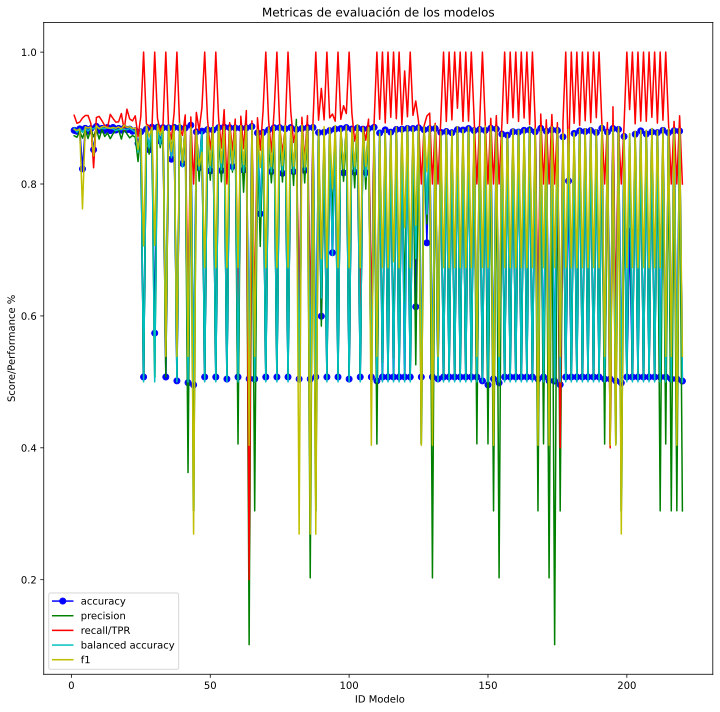

In [ ]:
# Se convierten listas en array para las gráficas
contador1=np.asarray(contador1)
acc_list1=np.asarray(acc_list1)
prec_list1=np.asarray(prec_list1)
rec_list1=np.asarray(rec_list1)
bal_acc_list1=np.asarray(bal_acc_list1)
f1_list1=np.array(f1_list1)
                
# crear gráficas superpuestas
plt.plot(contador1,acc_list1, color='b', label='accuracy', marker='o')
plt.plot(contador1,prec_list1, color='g', label='precision')
plt.plot(contador1,rec_list1, color='r', label='recall/TPR')
plt.plot(contador1,bal_acc_list1, color='c', label='balanced accuracy')
plt.plot(contador1,f1_list1, color='y', label='f1')

# nombre de ejes 
plt.xlabel(" ID Modelo")
plt.ylabel("Score/Performance %")
plt.title("Metricas de evaluación de los modelos")

# agregar leyenda, a partir de labels de cada grafica
plt.legend()
# mostrar grafica
plt.show()

In [ ]:
#Implementamos red con los hiperparámetros óptimos encontrados en paso anterior

# crear red neuronal óptima con los hiper parámetros sintonizados
ModeloMF_opt = MLPClassifier(hidden_layer_sizes =hidden_layers_opt1, activation=acts_opt1, alpha=regs_opt1) #Se fijan los hiperparámetros óptimos
# ajustar modelo óptimo con train-set de la base XMF
ModeloMF_opt.fit(XMF_train, y_train) #Se ajusta red con los datos de entrenamiento.

# cear vector de predicciones a partir de x-test
y_predict = ModeloMF_opt.predict(XMF_test)

print('El mejor modelo es el', cont_m1,'que tiene los siguientes hiperparámetros:')
print('Capas ocultas y cantidad de Neuronas:', hidden_layers_opt1)
print('Función de activación:', acts_opt1)
print('Regularización', regs_opt1)

#Almacenamiento Metricas

acc1 = round(accuracy_score(y_test, y_predict),5)
prec1 = round(precision_score(y_test, y_predict),5)
rec1 = round(recall_score(y_test, y_predict),5)
bal1 = round(balanced_accuracy_score(y_test, y_predict),5)
f1_1 = round(f1_score(y_test, y_predict),5)

# calcular metricas de evaluacion
print(f'Accuracy {round(accuracy_score(y_test, y_predict),5)}')
print(f'Precision {round(precision_score(y_test, y_predict),5)}')
print(f'Sensitivity/Recall {round(recall_score(y_test, y_predict),5)}')
print(f'Balanced Accuracy {round(balanced_accuracy_score(y_test, y_predict),5)}')
print(f'F1 {round(f1_score(y_test, y_predict),5)}')


#hiperpar1 = {
#    'hidden_layers': hidden_layers_opt1,
#    'Func_act': acts_opt1,
#    'reg': regs_opt1
#    }

#df_hiperparam1 = pd.DataFrame([[key, hiperpar1[key]] for key in hiperpar1.keys()], columns=['Hiperparámetros '+str(cont_m1), 'Valor'])
#df_hiperparam1.to_csv('mejor_HiperparamMF.csv')

modelo1  = {
    "Accuracy": acc1,
         "Precision":prec1,
         "Recall" : rec1,
         "Balanced Accuracy" : bal1,
         "F1": f1_1        
        }

df_metricas1 = pd.DataFrame([[key, modelo1[key]] for key in modelo1.keys()], columns=['Metricas del Modelo '+str(cont_m1), 'Valor'])

df_metricas1.to_csv('mejor_metricasMF.csv')

# crear matriz de confusion
#print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

df_metricas1

TypeError: '<=' not supported between instances of 'NoneType' and 'int'

In [ ]:
Mejor1=pd.read_csv('mejor_metricasMF.csv')
Mejor1

,Unnamed: 0,Metricas del Modelo 43,Valor
0,0,Accuracy,0.89778
1,1,Precision,0.88732
2,2,Recall,0.89573
3,3,Balanced Accuracy,0.89766
4,4,F1,0.89151


## Modelos ajustados con variables con poder predictivo medio a fuerte y con una interacciones

In [ ]:
#Se crea un vector con las arquitecturas de red a probar.
Estructura=[(5,5), (5,5,5),(10,10),(10,10,10),(20,20),(20,20,20),(50,50),(50,50,50),(100,100),(100,100,100),(50,10,100)]
Activacion = ['relu','logistic']  #Funciones de activación para probar
alfa = np.linspace(0,3,num=10) #Se generan 10 valores de regularizacion entre 0 y 3.


#Se incializan variables para saber cual es el mejor modelo creado.
accs_opt2 = 0
cont_m2 = None
hidden_layers_opt1 = None
acts_opt2 = None
regs_opt2 = None
# Se crean listas de las métricas de evaluación a graficar.
# crear lista de metricas de evaluacion a graficar
acc_list2 = []
prec_list2 = []
rec_list2 = []
bal_acc_list2 = []
f1_list2 = []
contador2 = []
cont2 = 1 # Contador que nos servira como id del modelo ajustado.
for reg in alfa:
    for est in Estructura:
        for act in Activacion:
            ModeloMFI = MLPClassifier(hidden_layer_sizes = est, activation=act, alpha=reg)
            res_acc = cross_val_score(ModeloMFI,XMFI_train, y_train, scoring='accuracy',n_jobs=-1)
            avg_acc = np.mean(res_acc)
            res_prec = cross_val_score(ModeloMFI,XMFI_train, y_train, scoring='precision',n_jobs=-1)
            avg_prec = round(np.mean(res_prec),4)
            res_rec = cross_val_score(ModeloMFI,XMFI_train, y_train, scoring='recall',n_jobs=-1)
            avg_rec = round(np.mean(res_rec),4)
            res_bal = cross_val_score(ModeloMFI,XMFI_train, y_train, scoring='balanced_accuracy',n_jobs=-1)
            avg_bal = round(np.mean(res_bal),4)
            res_f1 = cross_val_score(ModeloMFI,XMFI_train, y_train, scoring='f1',n_jobs=-1)
            avg_f1 = round(np.mean(res_f1),4)
            
            #Agregamos métricas de evaluación a la listas
            acc_list2.append(avg_acc)
            prec_list2.append(avg_prec)
            rec_list2.append(avg_rec)
            bal_acc_list2.append(avg_bal)
            f1_list2.append(avg_f1)
            contador2.append(cont2)
            
            
            print('Las métricas de evaluación del modelo '+ str(cont2)+' con estructura  [' +str(est)+ '] función de activación ' +str(act) + ' y regularización L2 ' + str(reg)+ ' son:'  )
            print('Accuracy: ' + str(avg_acc))
            print('Precision: ' + str(avg_prec))
            print('Recall: ' + str(avg_rec))
            print('Balance accuracy: ' + str(avg_bal))
            print('F1: ' + str(avg_f1))
            print(' ')
          
            
            #Dado que se evaluará la probabilidad de error del modelo, se escoge el mejor modelo con base en el Accuracy
            if avg_acc > accs_opt2:
                accs_opt2 = avg_acc
                hidden_layers_opt2 = est
                acts_opt2 = act
                regs_opt2 = reg
                cont_m2 = cont2
                  
            cont2 +=1
                

Las métricas de evaluación del modelo 1 con estructura  [(5, 5)] función de activación relu y regularización L2 0.0 son:
Accuracy: 0.882638888888889
Precision: 0.872
Recall: 0.8993
Balance accuracy: 0.8823
F1: 0.8852
 
Las métricas de evaluación del modelo 2 con estructura  [(5, 5)] función de activación logistic y regularización L2 0.0 son:
Accuracy: 0.8787500000000001
Precision: 0.8746
Recall: 0.9039
Balance accuracy: 0.8812
F1: 0.8842
 
Las métricas de evaluación del modelo 3 con estructura  [(5, 5, 5)] función de activación relu y regularización L2 0.0 son:
Accuracy: 0.8822222222222222
Precision: 0.8781
Recall: 0.896
Balance accuracy: 0.8809
F1: 0.8883
 
Las métricas de evaluación del modelo 4 con estructura  [(5, 5, 5)] función de activación logistic y regularización L2 0.0 son:
Accuracy: 0.8526388888888888
Precision: 0.8732
Recall: 0.7674
Balance accuracy: 0.8259
F1: 0.8085
 
Las métricas de evaluación del modelo 5 con estructura  [(10, 10)] función de activación relu y regulariz

Las métricas de evaluación del modelo 37 con estructura  [(50, 50, 50)] función de activación relu y regularización L2 0.3333333333333333 son:
Accuracy: 0.8873611111111112
Precision: 0.8821
Recall: 0.8998
Balance accuracy: 0.8875
F1: 0.8934
 
Las métricas de evaluación del modelo 38 con estructura  [(50, 50, 50)] función de activación logistic y regularización L2 0.3333333333333333 son:
Accuracy: 0.49847222222222226
Precision: 0.4058
Recall: 1.0
Balance accuracy: 0.5
F1: 0.5385
 
Las métricas de evaluación del modelo 39 con estructura  [(100, 100)] función de activación relu y regularización L2 0.3333333333333333 son:
Accuracy: 0.8901388888888888
Precision: 0.8811
Recall: 0.9003
Balance accuracy: 0.8887
F1: 0.8945
 
Las métricas de evaluación del modelo 40 con estructura  [(100, 100)] función de activación logistic y regularización L2 0.3333333333333333 son:
Accuracy: 0.8570833333333333
Precision: 0.8504
Recall: 0.8826
Balance accuracy: 0.8631
F1: 0.8685
 
Las métricas de evaluación de

Las métricas de evaluación del modelo 72 con estructura  [(10, 10)] función de activación logistic y regularización L2 1.0 son:
Accuracy: 0.8588888888888888
Precision: 0.8468
Recall: 0.911
Balance accuracy: 0.857
F1: 0.863
 
Las métricas de evaluación del modelo 73 con estructura  [(10, 10, 10)] función de activación relu y regularización L2 1.0 son:
Accuracy: 0.887361111111111
Precision: 0.877
Recall: 0.8987
Balance accuracy: 0.8887
F1: 0.8891
 
Las métricas de evaluación del modelo 74 con estructura  [(10, 10, 10)] función de activación logistic y regularización L2 1.0 son:
Accuracy: 0.507361111111111
Precision: 0.5074
Recall: 1.0
Balance accuracy: 0.5
F1: 0.6732
 
Las métricas de evaluación del modelo 75 con estructura  [(20, 20)] función de activación relu y regularización L2 1.0 son:
Accuracy: 0.887361111111111
Precision: 0.8706
Recall: 0.9009
Balance accuracy: 0.8868
F1: 0.8904
 
Las métricas de evaluación del modelo 76 con estructura  [(20, 20)] función de activación logistic y 

Las métricas de evaluación del modelo 108 con estructura  [(100, 100, 100)] función de activación logistic y regularización L2 1.3333333333333333 son:
Accuracy: 0.5043055555555556
Precision: 0.406
Recall: 1.0
Balance accuracy: 0.5
F1: 0.6732
 
Las métricas de evaluación del modelo 109 con estructura  [(50, 10, 100)] función de activación relu y regularización L2 1.3333333333333333 son:
Accuracy: 0.8883333333333333
Precision: 0.8861
Recall: 0.8995
Balance accuracy: 0.8898
F1: 0.8922
 
Las métricas de evaluación del modelo 110 con estructura  [(50, 10, 100)] función de activación logistic y regularización L2 1.3333333333333333 son:
Accuracy: 0.5043055555555556
Precision: 0.2029
Recall: 0.6
Balance accuracy: 0.5
F1: 0.5385
 
Las métricas de evaluación del modelo 111 con estructura  [(5, 5)] función de activación relu y regularización L2 1.6666666666666665 son:
Accuracy: 0.8780555555555555
Precision: 0.8701
Recall: 0.8938
Balance accuracy: 0.8759
F1: 0.8828
 
Las métricas de evaluación del

Las métricas de evaluación del modelo 143 con estructura  [(20, 20, 20)] función de activación relu y regularización L2 2.0 son:
Accuracy: 0.8869444444444443
Precision: 0.8752
Recall: 0.8897
Balance accuracy: 0.8864
F1: 0.889
 
Las métricas de evaluación del modelo 144 con estructura  [(20, 20, 20)] función de activación logistic y regularización L2 2.0 son:
Accuracy: 0.507361111111111
Precision: 0.5074
Recall: 1.0
Balance accuracy: 0.5
F1: 0.6732
 
Las métricas de evaluación del modelo 145 con estructura  [(50, 50)] función de activación relu y regularización L2 2.0 son:
Accuracy: 0.88375
Precision: 0.8724
Recall: 0.9025
Balance accuracy: 0.8836
F1: 0.886
 
Las métricas de evaluación del modelo 146 con estructura  [(50, 50)] función de activación logistic y regularización L2 2.0 son:
Accuracy: 0.50125
Precision: 0.2028
Recall: 0.6
Balance accuracy: 0.5
F1: 0.5386
 
Las métricas de evaluación del modelo 147 con estructura  [(50, 50, 50)] función de activación relu y regularización L2 2

Las métricas de evaluación del modelo 179 con estructura  [(5, 5, 5)] función de activación relu y regularización L2 2.6666666666666665 son:
Accuracy: 0.8802777777777777
Precision: 0.8677
Recall: 0.8938
Balance accuracy: 0.8769
F1: 0.8813
 
Las métricas de evaluación del modelo 180 con estructura  [(5, 5, 5)] función de activación logistic y regularización L2 2.6666666666666665 son:
Accuracy: 0.507361111111111
Precision: 0.5074
Recall: 1.0
Balance accuracy: 0.5
F1: 0.6732
 
Las métricas de evaluación del modelo 181 con estructura  [(10, 10)] función de activación relu y regularización L2 2.6666666666666665 son:
Accuracy: 0.8800000000000001
Precision: 0.8685
Recall: 0.9012
Balance accuracy: 0.8782
F1: 0.882
 
Las métricas de evaluación del modelo 182 con estructura  [(10, 10)] función de activación logistic y regularización L2 2.6666666666666665 son:
Accuracy: 0.507361111111111
Precision: 0.5074
Recall: 1.0
Balance accuracy: 0.5
F1: 0.6732
 
Las métricas de evaluación del modelo 183 con

Las métricas de evaluación del modelo 215 con estructura  [(100, 100)] función de activación relu y regularización L2 3.0 son:
Accuracy: 0.8799999999999999
Precision: 0.8683
Recall: 0.902
Balance accuracy: 0.8796
F1: 0.8838
 
Las métricas de evaluación del modelo 216 con estructura  [(100, 100)] función de activación logistic y regularización L2 3.0 son:
Accuracy: 0.4981944444444445
Precision: 0.4058
Recall: 0.8
Balance accuracy: 0.5
F1: 0.5386
 
Las métricas de evaluación del modelo 217 con estructura  [(100, 100, 100)] función de activación relu y regularización L2 3.0 son:
Accuracy: 0.8847222222222222
Precision: 0.8672
Recall: 0.8998
Balance accuracy: 0.8815
F1: 0.8868
 
Las métricas de evaluación del modelo 218 con estructura  [(100, 100, 100)] función de activación logistic y regularización L2 3.0 son:
Accuracy: 0.5043055555555556
Precision: 0.5074
Recall: 0.6
Balance accuracy: 0.5
F1: 0.4039
 
Las métricas de evaluación del modelo 219 con estructura  [(50, 10, 100)] función de ac

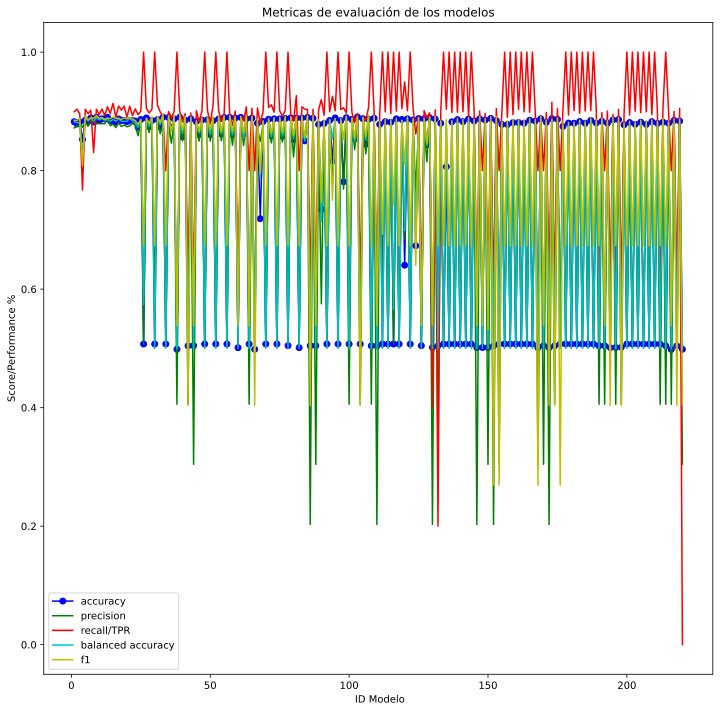

In [ ]:
# Se convierten listas en array para las gráficas
contador2=np.asarray(contador2)
acc_list2=np.asarray(acc_list2)
prec_list2=np.asarray(prec_list2)
rec_list2=np.asarray(rec_list2)
bal_acc_list2=np.asarray(bal_acc_list2)
f1_list2=np.array(f1_list2)
                
# crear gráficas superpuestas
plt.plot(contador2,acc_list2, color='b', label='accuracy', marker='o')
plt.plot(contador2,prec_list2, color='g', label='precision')
plt.plot(contador2,rec_list2, color='r', label='recall/TPR')
plt.plot(contador2,bal_acc_list2, color='c', label='balanced accuracy')
plt.plot(contador2,f1_list2, color='y', label='f1')

# nombre de ejes 
plt.xlabel(" ID Modelo")
plt.ylabel("Score/Performance %")
plt.title("Metricas de evaluación de los modelos")

# agregar leyenda, a partir de labels de cada grafica
plt.legend()
# mostrar grafica
plt.show()

In [ ]:
#Implementamos red con los hiperparámetros óptimos encontrados en paso anterior

# crear red neuronal óptima con los hiper parámetros sintonizados
ModeloMFI_opt = MLPClassifier(hidden_layer_sizes =hidden_layers_opt2, activation=acts_opt2, alpha=regs_opt2) #Se fijan los hiperparámetros óptimos
# ajustar modelo óptimo con train-set de la base XMF
ModeloMFI_opt.fit(XMFI_train, y_train) #Se ajusta red con los datos de entrenamiento.

# cear vector de predicciones a partir de x-test
y_predict = ModeloMFI_opt.predict(XMFI_test)

print('El mejor modelo es el', cont_m2,'que tiene los siguientes hiperparámetros:')
print('Capas ocultas y cantidad de Neuronas:', hidden_layers_opt2)
print('Función de activación:', acts_opt2)
print('Regularización', regs_opt2)

#Almacenamiento Metricas

acc2 = round(accuracy_score(y_test, y_predict),5)
prec2 = round(precision_score(y_test, y_predict),5)
rec2 = round(recall_score(y_test, y_predict),5)
bal2 = round(balanced_accuracy_score(y_test, y_predict),5)
f1_2 = round(f1_score(y_test, y_predict),5)

# calcular metricas de evaluacion
print(f'Accuracy {round(accuracy_score(y_test, y_predict),5)}')
print(f'Precision {round(precision_score(y_test, y_predict),5)}')
print(f'Sensitivity/Recall {round(recall_score(y_test, y_predict),5)}')
print(f'Balanced Accuracy {round(balanced_accuracy_score(y_test, y_predict),5)}')
print(f'F1 {round(f1_score(y_test, y_predict),5)}')


# crear matriz de confusion
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

hiperpar2 ={
    'hidden_layers': hidden_layers_opt2,
    'Func_act': acts_opt2,
    'reg': regs_opt2}

df_hiperparam1 = pd.DataFrame([[key, hiperpar2[key]] for key in hiperpar2.keys()], columns=['Hiperparametros '+str(cont_m2), 'Valor'])
df_hiperparam1.to_csv('mejor_HiperparamMF.csv')

modelo2  = {
    "Accuracy": acc2,
         "Precision":prec2,
         "Recall" : rec2,
         "Balanced Accuracy" : bal2,
         "F1": f1_2        
        }

df_metricas2 = pd.DataFrame([[key, modelo2[key]] for key in modelo2.keys()], columns=['Metricas del Modelo '+str(cont_m2), 'Valor'])

df_metricas2.to_csv('mejor_metricasMFI.csv')


El mejor modelo es el 103 que tiene los siguientes hiperparámetros:
Capas ocultas y cantidad de Neuronas: (50, 50, 50)
Función de activación: relu
Regularización 1.3333333333333333
Accuracy 0.89278
Precision 0.872
Sensitivity/Recall 0.90403
Balanced Accuracy 0.89344
F1 0.88773
     0    1
0  844  112
1   81  763


In [ ]:
df_hiperparam1

In [ ]:
df_metricas2

## Modelos ajustados solamente en las variables con capacidad predictiva fuerte

In [ ]:
#Se crea un vector con las arquitecturas de red a probar.
Estructura=[(5,5), (5,5,5),(10,10),(10,10,10),(20,20),(20,20,20),(50,50),(50,50,50),(100,100),(100,100,100),(50,10,100)]
Activacion = ['relu','logistic']  #Funciones de activación para probar
alfa = np.linspace(0,3,num=10) #Se generan 10 valores de regularizacion entre 0 y 3.


#Se incializan variables para saber cual es el mejor modelo creado.
accs_opt3 = 0
cont_m3 = None
hidden_layers_opt1 = None
acts_opt3 = None
regs_opt3 = None
# Se crean listas de las métricas de evaluación a graficar.
# crear lista de metricas de evaluacion a graficar
acc_list3 = []
prec_list3 = []
rec_list3 = []
bal_acc_list3 = []
f1_list3 = []
contador3 = []
cont3 = 1 # Contador que nos servira como id del modelo ajustado.
for reg in alfa:
    for est in Estructura:
        for act in Activacion:
            ModeloF = MLPClassifier(hidden_layer_sizes = est, activation=act, alpha=reg)
            res_acc = cross_val_score(ModeloF,XF_train, y_train, scoring='accuracy',n_jobs=-1)
            avg_acc = np.mean(res_acc)
            res_prec = cross_val_score(ModeloF,XF_train, y_train, scoring='precision',n_jobs=-1)
            avg_prec = round(np.mean(res_prec),4)
            res_rec = cross_val_score(ModeloF,XF_train, y_train, scoring='recall',n_jobs=-1)
            avg_rec = round(np.mean(res_rec),4)
            res_bal = cross_val_score(ModeloF,XF_train, y_train, scoring='balanced_accuracy',n_jobs=-1)
            avg_bal = round(np.mean(res_bal),4)
            res_f1 = cross_val_score(ModeloF,XF_train, y_train, scoring='f1',n_jobs=-1)
            avg_f1 = round(np.mean(res_f1),4)
            
            #Agregamos métricas de evaluación a la listas
            acc_list3.append(avg_acc)
            prec_list3.append(avg_prec)
            rec_list3.append(avg_rec)
            bal_acc_list3.append(avg_bal)
            f1_list3.append(avg_f1)
            contador3.append(cont3)
            
            
            print('Las métricas de evaluación del modelo '+ str(cont3)+' con estructura  [' +str(est)+ '] función de activación ' +str(act) + ' y regularización L2 ' + str(reg)+ ' son:'  )
            print('Accuracy: ' + str(avg_acc))
            print('Precision: ' + str(avg_prec))
            print('Recall: ' + str(avg_rec))
            print('Balance accuracy: ' + str(avg_bal))
            print('F1: ' + str(avg_f1))
            print(' ')
          
            
            #Dado que se evaluará la probabilidad de error del modelo, se escoge el mejor modelo con base en el Accuracy
            if avg_acc > accs_opt3:
                accs_opt3 = avg_acc
                hidden_layers_opt3 = est
                acts_opt3 = act
                regs_opt3 = reg
                cont_m3 = cont3
                  
            cont3 +=1
                

In [ ]:
# Se convierten listas en array para las gráficas
contador3=np.asarray(contador3)
acc_list3=np.asarray(acc_list3)
prec_list3=np.asarray(prec_list3)
rec_list3=np.asarray(rec_list3)
bal_acc_list3=np.asarray(bal_acc_list3)
f1_list3=np.array(f1_list3)
                
# crear gráficas superpuestas
plt.plot(contador3,acc_list3, color='b', label='accuracy', marker='o')
plt.plot(contador3,prec_list3, color='g', label='precision')
plt.plot(contador3,rec_list3, color='r', label='recall/TPR')
plt.plot(contador3,bal_acc_list3, color='c', label='balanced accuracy')
plt.plot(contador3,f1_list3, color='y', label='f1')

# nombre de ejes 
plt.xlabel(" ID Modelo")
plt.ylabel("Score/Performance %")
plt.title("Metricas de evaluación de los modelos")

# agregar leyenda, a partir de labels de cada grafica
plt.legend()
# mostrar grafica
plt.show()

In [ ]:
#Implementamos red con los hiperparámetros óptimos encontrados en paso anterior

# crear red neuronal óptima con los hiper parámetros sintonizados
ModeloF_opt = MLPClassifier(hidden_layer_sizes =hidden_layers_opt3, activation=acts_opt3, alpha=regs_opt3) #Se fijan los hiperparámetros óptimos
# ajustar modelo óptimo con train-set de la base XF
ModeloF_opt.fit(XF_train, y_train) #Se ajusta red con los datos de entrenamiento.

# cear vector de predicciones a partir de x-test
y_predict = ModeloF_opt.predict(XF_test)

print('El mejor modelo es el', cont_m3,'que tiene los siguientes hiperparámetros:')
print('Capas ocultas y cantidad de Neuronas:', hidden_layers_opt3)
print('Función de activación:', acts_opt3)
print('Regularización', regs_opt3)

# Se gardan las métricas del mejor modelo
acc3 = round(accuracy_score(y_test, y_predict),5)
prec3 = round(precision_score(y_test, y_predict),5)
rec3 = round(recall_score(y_test, y_predict),5)
bal3 = round(balanced_accuracy_score(y_test, y_predict),5)
f1_3 = round(f1_score(y_test, y_predict),5)

# calcular metricas de evaluacion
print(f'Accuracy {round(accuracy_score(y_test, y_predict),5)}')
print(f'Precision {round(precision_score(y_test, y_predict),5)}')
print(f'Sensitivity/Recall {round(recall_score(y_test, y_predict),5)}')
print(f'Balanced Accuracy {round(balanced_accuracy_score(y_test, y_predict),5)}')
print(f'F1 {round(f1_score(y_test, y_predict),5)}')


# crear matriz de confusion
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

## Modelo ajustado con variables que tienen poder predictivo fuerte y al menos una interacción

In [ ]:
#Se crea un vector con las arquitecturas de red a probar.
Estructura=[(5,5), (5,5,5),(10,10),(10,10,10),(20,20),(20,20,20),(50,50),(50,50,50),(100,100),(100,100,100),(50,10,100)]
Activacion = ['relu','logistic']  #Funciones de activación para probar
alfa = np.linspace(0,3,num=10) #Se generan 10 valores de regularizacion entre 0 y 3.


#Se incializan variables para saber cual es el mejor modelo creado.
accs_opt4 = 0
cont_m4 = None
hidden_layers_opt1 = None
acts_opt4 = None
regs_opt4 = None
# Se crean listas de las métricas de evaluación a graficar.
# crear lista de metricas de evaluacion a graficar
acc_list4 = []
prec_list4 = []
rec_list4 = []
bal_acc_list4 = []
f1_list4 = []
contador4 = []
cont4 = 1 # Contador que nos servira como id del modelo ajustado.
for reg in alfa:
    for est in Estructura:
        for act in Activacion:
            ModeloFI = MLPClassifier(hidden_layer_sizes = est, activation=act, alpha=reg)
            res_acc = cross_val_score(ModeloFI,XFI_train, y_train, scoring='accuracy',n_jobs=-1)
            avg_acc = np.mean(res_acc)
            res_prec = cross_val_score(ModeloFI,XFI_train, y_train, scoring='precision',n_jobs=-1)
            avg_prec = round(np.mean(res_prec),4)
            res_rec = cross_val_score(ModeloFI,XFI_train, y_train, scoring='recall',n_jobs=-1)
            avg_rec = round(np.mean(res_rec),4)
            res_bal = cross_val_score(ModeloFI,XFI_train, y_train, scoring='balanced_accuracy',n_jobs=-1)
            avg_bal = round(np.mean(res_bal),4)
            res_f1 = cross_val_score(ModeloFI,XFI_train, y_train, scoring='f1',n_jobs=-1)
            avg_f1 = round(np.mean(res_f1),4)
            
            #Agregamos métricas de evaluación a la listas
            acc_list4.append(avg_acc)
            prec_list4.append(avg_prec)
            rec_list4.append(avg_rec)
            bal_acc_list4.append(avg_bal)
            f1_list4.append(avg_f1)
            contador4.append(cont4)
            
            
            print('Las métricas de evaluación del modelo '+ str(cont4)+' con estructura  [' +str(est)+ '] función de activación ' +str(act) + ' y regularización L2 ' + str(reg)+ ' son:'  )
            print('Accuracy: ' + str(avg_acc))
            print('Precision: ' + str(avg_prec))
            print('Recall: ' + str(avg_rec))
            print('Balance accuracy: ' + str(avg_bal))
            print('F1: ' + str(avg_f1))
            print(' ')
          
            
            #Dado que se evaluará la probabilidad de error del modelo, se escoge el mejor modelo con base en el Accuracy
            if avg_acc > accs_opt4:
                accs_opt4 = avg_acc
                hidden_layers_opt4 = est
                acts_opt4 = act
                regs_opt4 = reg
                cont_m4 = cont4
                  
            cont4 +=1
                

In [ ]:
# Se convierten listas en array para las gráficas
contador4=np.asarray(contador4)
acc_list4=np.asarray(acc_list4)
prec_list4=np.asarray(prec_list4)
rec_list4=np.asarray(rec_list4)
bal_acc_list4=np.asarray(bal_acc_list4)
f1_list4=np.array(f1_list4)
                
# crear gráficas superpuestas
plt.plot(contador4,acc_list4, color='b', label='accuracy', marker='o')
plt.plot(contador4,prec_list4, color='g', label='precision')
plt.plot(contador4,rec_list4, color='r', label='recall/TPR')
plt.plot(contador4,bal_acc_list4, color='c', label='balanced accuracy')
plt.plot(contador4,f1_list4, color='y', label='f1')

# nombre de ejes 
plt.xlabel(" ID Modelo")
plt.ylabel("Score/Performance %")
plt.title("Metricas de evaluación de los modelos")

# agregar leyenda, a partir de labels de cada grafica
plt.legend()
# mostrar grafica
plt.show()

In [ ]:
#Implementamos red con los hiperparámetros óptimos encontrados en paso anterior

# crear red neuronal óptima con los hiper parámetros sintonizados
ModeloFI_opt = MLPClassifier(hidden_layer_sizes =hidden_layers_opt4, activation=acts_opt4, alpha=regs_opt4) #Se fijan los hiperparámetros óptimos
# ajustar modelo óptimo con train-set de la base XMF
ModeloFI_opt.fit(XFI_train, y_train) #Se ajusta red con los datos de entrenamiento.

# cear vector de predicciones a partir de x-test
y_predict = ModeloFI_opt.predict(XFI_test)

print('El mejor modelo es el', cont_m4,'que tiene los siguientes hiperparámetros:')
print('Capas ocultas y cantidad de Neuronas:', hidden_layers_opt4)
print('Función de activación:', acts_opt4)
print('Regularización', regs_opt4)

#Se guardan las métricas del mejor modelo
acc4 = round(accuracy_score(y_test, y_predict),5)
prec4 = round(precision_score(y_test, y_predict),5)
rec4 = round(recall_score(y_test, y_predict),5)
bal4 = round(balanced_accuracy_score(y_test, y_predict),5)
f1_4 = round(f1_score(y_test, y_predict),5)

# calcular metricas de evaluacion
print(f'Accuracy {round(accuracy_score(y_test, y_predict),5)}')
print(f'Precision {round(precision_score(y_test, y_predict),5)}')
print(f'Sensitivity/Recall {round(recall_score(y_test, y_predict),5)}')
print(f'Balanced Accuracy {round(balanced_accuracy_score(y_test, y_predict),5)}')
print(f'F1 {round(f1_score(y_test, y_predict),5)}')


# crear matriz de confusion
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

# Comparación de los mejores modelos de cada grupo y selección del mejor general

In [ ]:
#Se crea la lista con las metricas de los cuatro mejores modelos obtenidos
acc_list_opt = []
prec_list_opt = []
rec_list_opt = []
bal_list_opt = []
f1_list_opt = []
modelos_m =[]


acc_list_opt.append(acc1)
acc_list_opt.append(acc2)
acc_list_opt.append(acc3)
acc_list_opt.append(acc4)

prec_list_opt.append(prec1)
prec_list_opt.append(prec2)
prec_list_opt.append(prec3)
prec_list_opt.append(prec4)

rec_list_opt.append(rec1)
rec_list_opt.append(rec2)
rec_list_opt.append(rec3)
rec_list_opt.append(rec4)

bal_list_opt.append(bal1)
bal_list_opt.append(bal2)
bal_list_opt.append(bal3)
bal_list_opt.append(bal4)

f1_list_opt.append(f1_1)
f1_list_opt.append(f1_2)
f1_list_opt.append(f1_3)
f1_list_opt.append(f1_4)

modelos_m.append(cont_m1)
modelos_m.append(cont_m2)
modelos_m.append(cont_m3)
modelos_m.append(cont_m4)

# Se convierten listas en array para las gráficas
modelos_m=np.asarray(modelos_m)
acc_list_opt=np.asarray(acc_list_opt)
prec_list_opt=np.asarray(prec_list_opt)
rec_list_opt=np.asarray(rec_list_opt)
bal_list_opt=np.asarray(bal_list_opt)
f1_list_opt=np.array(f1_list_opt)
                
# crear gráficas superpuestas
plt.plot(modelos_m,acc_list_opt, color='b', label='accuracy')
plt.plot(modelos_m,prec_list_opt, color='g', label='precision')
plt.plot(modelos_m,rec_list_opt, color='r', label='recall/TPR')
plt.plot(modelos_m,bal_list_opt, color='c', label='balanced accuracy')
plt.plot(modelos_m,f1_list_opt, color='y', label='f1')

# nombre de ejes 
plt.xlabel(" ID Modelo")
plt.ylabel("Score/Performance %")
plt.title("Metricas de evaluación de los modelos")

# agregar leyenda, a partir de labels de cada grafica
plt.legend()
# mostrar grafica
plt.show()

In [ ]:
# crear DataFrame de resultados 

data  = { "Accuracy": [acc1, acc2],
         "Precision":[prec1, prec2],
         "Recall" : [rec1, rec2],
         "Balanced Accuracy" : [bal1, bal2],
         "F1": [f1_1, f1_2]        
        }

df_res = pd.DataFrame (data, index = [str(cont_m1),str(cont_m2)])

df_res

In [ ]:
# crear vector de predicciones del mejor modelo de todas las especificaciones con x-test para generar y_test

y_test  = 


